## Translation with a Sequence to Sequence Network and Attention

In [5]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import unicodedata
import codecs
import string
import re
import random
import time
import math
import numpy as np

import torch as t
import torch.nn as nn
from torch.autograd import Variable as V
import torch.utils.data as Data
import torch.nn.functional as F
from torchvision import datasets, models
from torchvision import transforms as T
import torch.optim as optim

### 1.Load data


#### indexing words

In [6]:
SOS_token = 0
EOS_token = 1

class Lang:
    
    def __init__(self, name):
        self.word2count = {}
        self.word2index = {}
        self.index2word = {0:"SOS", 1:"EOS"}
        self.n_words = 2  # Count SOS and EOS
    
    
    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)
    
    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

#### Reading and decoding files

In [7]:
# Files are all in Unicode, turn Unicode characters to ASCII
# Turn a Unicode string to plain ASCII
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


# Lowercase, trim, and remove non-letter character
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]", r" ", s)
    return s

# Read the files we split file into lines, and then split lines into pairs.
# The files are all English to other language.
# if we want to translate from Other language to English added reverse flag to reverse pairs.
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")
    
    # Read the file and split into lines
    with codecs.open('./data/eng-fra/%s_%s.txt' % (lang1, lang2), 'r', 'utf-8') as f:
        lines = f.readlines()
        
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in line.split('\t')] for line in lines]
    
    # Reverse pairs, make Lang instance
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs
  

#### Filtering sentences

we'll trim the data set to only relatively short and simple sentences.
Here the maximum length is 10 words

In [8]:
MAX_LENGTH = 10

good_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
p[0].startswith(good_prefixes)


def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]


The full process for preparing the data is:
* * *
- Read text file and split into lines, split lines into pairs
- Normalize text filter by length and content
- Make word lists from sentences in pairs
* * *

In [9]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %d sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %d sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])
        
    return input_lang, output_lang, pairs


In [10]:
input_lang, output_lang, pairs = prepare_data('eng', 'fra')

# Print an example pair
print(random.choice(pairs))
    

Reading lines...
Read 149861 sentence pairs
Trimmed to 9551 sentence pairs
Indexing words...
[u'you re pathetic .', u'vous etes pathetique .']


#### Turning training data into Tensors/Variables

In [11]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    
    # Add EOS_token
    indexes.append(EOS_token)
    var = V(t.LongTensor(indexes).view(-1, 1))
    if t.cuda.is_available():
        var = var.cuda()
    return var

def variable_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    output_variable = variable_from_sentence(output_lang, pair[1])
    return input_variable, output_variable

### 2.Build models

#### The Encoder

In [12]:
class EncoderRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(num_embeddings=input_size, 
                                      embedding_dim=hidden_size)
        self.gru = nn.GRU(input_size=hidden_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers)
        
    
    def forward(self, word_inputs, hidden):
        # word_inputs: [234, 45, 23, 25, 1]
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        # for gru: input size: [seq_len, batch_size, embeddding_dim]
        embedded  = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    
    def init_hidden(self):
        hidden = V(t.zeros((self.num_layers, 1, self.hidden_size)))
        if t.cuda.is_available():
            hidden = hidden.cuda()
        return hidden   

#### Attention Decoder

Interpreting the Bahdanau et al. model 

The decoder's inputs are the last RNN hidden state $s_{i-1}$, last output $y_{i-1}$, and 
all encoder outputs $h$.

- embedding layer with inputs $y_{i-1}$
  - embedded = embedding(last_rnn_output)
- attention layer $\alpha$ with inputs ($s_{i-1}$, $h_j$) and outputs $e_{ij}$, normalized to create $\alpha_{ij}$
  - attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])
  - attn_weights = normalize(attn_energies)
- context vector $c_{i}$ as an attention-weighted average of encoder outputs
  - context = sum(attn_weights * encoder_outputs)
- RNN layer(s) f with inputs($s_{i-1}$,$y_{i-1}$,$c_{i}$) and internal hidden state, outputting $s_{i}$
  - rnn_input = concat(embedded, context)
  - rnn_output, rnn_hidden = rnn(rnn_input, last_hidden)
- an output layer g with inputs($y_{i-1}$, $s_i$, $c_i$), outputting $y_i$
  - output = out(embedded, rnn_output, context)

In [10]:
class BahdanauAttnDecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size, num_layers=1, dropout_p=0.1):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # define layers
        self.embedding = nn.Embedding(num_embeddings=output_size, embedding_dim=hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = GeneralAttn(hidden_size)
        self.gru = nn.GRU(input_size=hidden_size * 2,
                          hidden_size=hidden_size, 
                          num_layers=num_layers, 
                          dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note that we will only be running forward for a single decoder time step,
        # but will use all encoder outputs
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1)  # S = 1 * B * N
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B * 1 * N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = t.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0)     # B * N
        output = F.log_softmax(self.out(t.cat((output, context), 1)))
        
        # Return final output, hidden state, and attention weights(for visualization)
        return output, hidden, attn_weights


#### Interpreting the Luong et al. model(s)

$$\alpha_{t}(s) = align(h_t, \bar{h_s}) = \frac{exp(score(h_t, \bar{h_s}))}{\sum_{s'}exp(score(h_t, \bar{h_{s'}}))}$$


$$\begin{equation}
score(h_t, \bar{h_s}) = \left\{
\begin{aligned}
h_t^T\bar{h_s} & & dot    \\
h_t^TW_{\alpha}\bar{h_s} & & general    \\
v_{\alpha}^TW_{\alpha}[h_t;\bar{h_s}] & & concat   \\
\end{aligned}
\right.
\end{equation}$$

式子中,$h_t$, $\bar{h_s}$分别表示decoder, encoder的hidden state, 根据decoder的hidden和encoder的ouput来计算attention 权重


In [9]:
class Attn(nn.Module):
    
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(hidden_size * 2, hidden_size)
            self.other = nn.Parameter(t.FloatTensor(1, hidden_size))
        
    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)
        
        # Create variable to store attention energies
        attn_energies = V(t.zeros(seq_len))    # B * 1 * S
        if t.cuda.is_available():
            attn_energies = attn_energies.cuda()
            
        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])
        
        # Normalize energies to weights in range 0 to 1, resize to 1 * 1 * seq_len
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)

    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
    
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        else:
            energy = self.attn(t.cat((hidden, encoder_output)), 1)
            energy = self.other.dot(energy)
            return energy     

Now we can build a decoder that plugs this Attn module in after the RNN to calculate attention weight, and apply those weights to the encoder outputs to get a context vector.

In [10]:
class AttnDecoderRNN(nn.Module):
    
    def __init__(self, attn_model, hidden_size, output_size, 
                 num_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(num_embeddings=output_size, 
                                      embedding_dim=hidden_size)
        self.gru = nn.GRU(input_size=hidden_size * 2,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
            
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # word_input: embedding_dim
        # Get the embedding of the current input word(last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1)   # S = 1 * B * N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = t.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)
        
        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))   # B * 1 * N
        
        # Final output layer (next word prediction) using the RNN hidden 
        # state and context vector
        rnn_output = rnn_output.squeeze(0)     # S = 1 * B * N ---> B * N
        context = context.squeeze(1)           # B * S = B * 1 * N ---> B * N
        output = F.log_softmax(self.out(t.cat((rnn_output, context), 1)))
        
        # Return final output, hidden_state, and attention weights (for visualization)
        return output, context, hidden, attn_weights
        

#### Testing model

To make sure the Encoder and Decoder model are working (and working together) we'll 
do a quick test with fake word inputs

##### test encoder

In [11]:
encoder_test = EncoderRNN(input_size=10, hidden_size=10, num_layers=2)
print("encoder_test: ", encoder_test)

encoder_hidden = encoder_test.init_hidden()
print("encoder_hidden: ", encoder_hidden)
word_input = V(t.LongTensor([1, 2, 3]))
if t.cuda.is_available():
    encoder_test.cuda()
    word_input = word_input.cuda()
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

print("encoder outputs: ",encoder_outputs.size())
print("encoder hidden: ", encoder_hidden.size())

# print(encoder_outputs[-1] == encoder_hidden[-1])


encoder_test:  EncoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
encoder_hidden:  Variable containing:
(0 ,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(1 ,.,.) = 
   0   0   0   0   0   0   0   0   0   0
[torch.cuda.FloatTensor of size 2x1x10 (GPU 0)]

encoder outputs:  torch.Size([3, 1, 10])
encoder hidden:  torch.Size([2, 1, 10])


##### test decoder

In [12]:
decoder_test = AttnDecoderRNN(attn_model='general', 
                              hidden_size=10,
                              output_size=10,
                              num_layers=2)
print("decoder_test: ", decoder_test)


word_inputs = V(t.LongTensor([1, 2, 3]))
decoder_attns = t.zeros(1, 3, 3)
decoder_hidden = encoder_hidden
decoder_context = V(t.zeros(1, decoder_test.hidden_size))

if t.cuda.is_available():
    decoder_test.cuda()
    word_inputs = word_inputs.cuda()
    decoder_context = decoder_context.cuda()

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = \
    decoder_test(word_inputs[i], decoder_context, decoder_hidden, encoder_outputs)
    
    print("decoder output: ", decoder_output.size(),
          "decoder hidden: ", decoder_hidden.size(),
          "decoder attn: ", decoder_attn.size())
    decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data


decoder_test:  AttnDecoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear(in_features=20, out_features=10)
  (attn): Attn(
    (attn): Linear(in_features=10, out_features=10)
  )
)
decoder output:  torch.Size([1, 10]) decoder hidden:  torch.Size([2, 1, 10]) decoder attn:  torch.Size([1, 1, 3])
decoder output:  torch.Size([1, 10]) decoder hidden:  torch.Size([2, 1, 10]) decoder attn:  torch.Size([1, 1, 3])
decoder output:  torch.Size([1, 10]) decoder hidden:  torch.Size([2, 1, 10]) decoder attn:  torch.Size([1, 1, 3])


/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


#### Train model

In [13]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    loss = 0  # Added onto for each word
    
    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = V(t.LongTensor([[SOS_token]]))
    decoder_context = V(t.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden  # Use last hidden state from encoder to start decoder

    if t.cuda.is_available():
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()
    
    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    
    if use_teacher_forcing:
        # Teacher forcing: Use the ground-truch target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = \
                decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs) 
            # print("decoder_output size: ", decoder_output[0].size())
            # print("target_variable size: ", target_variable[di].size())
            
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]    # Next target is next input
    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = \
                decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoder_input = V(t.LongTensor([[ni]]))   # Chosen word is next input
            if t.cuda.is_available():
                decoder_input = decoder_input.cuda()
            
            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: 
                break
        
        # Backpropagation
        loss.backward()
        t.nn.utils.clip_grad_norm(encoder.parameters(), clip)
        t.nn.utils.clip_grad_norm(decoder.parameters(), clip)
        encoder_optimizer.step()
        decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [14]:
# Helper function to print time elapsed and estimated time remaining
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (- %s)" % (as_minutes(s), as_minutes(rs))


#### run training

With everything in place we can actually initialize a network and start training.
To start, we initialize models, optimizers, and a loss function(criterion)

In [15]:
print("input language num words: ", input_lang.n_words)
print("output language num words: ", output_lang.n_words)

input language num words:  2768
output language num words:  4015


In [18]:
attn_model = 'general'
hidden_size = 500
num_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(input_size=input_lang.n_words,          # 2768
                     hidden_size=hidden_size, 
                     num_layers=num_layers)                  # 2
decoder = AttnDecoderRNN(attn_model=attn_model, 
                         hidden_size=hidden_size, 
                         output_size=output_lang.n_words,    # 4015
                         num_layers=num_layers,              # 2
                         dropout_p=dropout_p)

# Move models to GPU
if t.cuda.is_available():
    encoder.cuda()
    decoder.cuda()
print("encoder: ", encoder)
print("decoder: ", decoder)

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

encoder:  EncoderRNN(
  (embedding): Embedding(2768, 500)
  (gru): GRU(500, 500, num_layers=2)
)
decoder:  AttnDecoderRNN(
  (embedding): Embedding(4015, 500)
  (gru): GRU(1000, 500, num_layers=2, dropout=0.05)
  (out): Linear(in_features=1000, out_features=4015)
  (attn): Attn(
    (attn): Linear(in_features=500, out_features=500)
  )
)


Then set up variables for plotting and tracking progress

In [19]:
# Configuring training
n_epochs = 5000
plot_every = 200
print_every = 1000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0     # Reset every print_every
plot_loss_total = 0      # Reset every plot_every


In [20]:
# Begin
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variable_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]
    
    # Run the train function
    loss = train(input_variable, target_variable, 
                 encoder, decoder, 
                 encoder_optimizer, decoder_optimizer, criterion)
    
    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    
    if epoch == 0: continue
    
    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % \
                        (time_since(start, epoch / n_epochs),
                         epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_avg = 0 

/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

#### Plotting training loss

Plotting is done with matplotlib, using the array plot_losses that was created while training.

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)  # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

#### Evaluating the network

Evaluation is mostly the same as training, but there are no targets. Instead we always feed the decoder's predictions back to itself. Every time it predicts a word, we add it to the output string. If it predicts the EOS token we stop there. We also store the decoder's 
attention outputs for each step to display later.

In [32]:
def evaluate(sentence, max_length=MAX_LENGTH):
    
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Create starting vectors for decoder
    decoder_input = V(t.LongTensor([SOS_token]))   # SOS
    decoder_context = V(t.zeros(1, decoder.hidden_size))
    
    if t.cuda.is_available():
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()
    
    decoder_hidden = encoder_hidden
    decoder_words = []
    decoder_attentions = t.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        
        decoder_output, decoder_context, decoder_hidden, decoder_attention = \
            decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        decoder_attentions[di, :decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data
        
        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoder_words.append('<EOS>')
            break
        else:
            decoder_words.append(output_lang.index2word[ni])
        
        # Next input is chosen word
        decoder_input = V(t.LongTensor([[ni]]))
        if t.cuda.is_available():
            decoder_input = decoder_input.cuda()
    return decoder_words, decoder_attentions[:di+1, :len(encoder_outputs)]


In [33]:
# evaluate random sentences from the training set and print out the input, target, and 
# output to make some subjective quality judgements
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('raw input: ', pair[0])
    print('target: ', pair[1])
    print('predict output: ', output_sentence)
    print(' ')

In [34]:
evaluate_randomly()

raw input:  you re all set .
target:  vous etes tous prets .
predict output:  pareille deborde concentration troubles abandonne concentration honte abandonne honte fixee
 


/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


#### Visualizing attention
A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run plt.matshow(attentions) to see attention output displayed as a matrix, with the columns being input steps and rows being output steps.

input sentence:  i m not going to get involved .
target_sentence:  je suis une femme mariee .
output words:  [u'asociale', u'asociale', u'confronte', u'asociale', u'idiots', u'excellent', u'malade', u'malade', u'polies', u'commande']
attentions:  
 0.0928  0.1033  0.1125  0.1138  0.1499  0.1493  0.1127  0.0906  0.0751
 0.0915  0.1019  0.1129  0.1182  0.1466  0.1429  0.1110  0.0917  0.0832
 0.0914  0.0984  0.1052  0.1216  0.1433  0.1472  0.1138  0.0886  0.0904
 0.1010  0.1014  0.1114  0.1123  0.1248  0.1264  0.1125  0.1015  0.1088
 0.0970  0.1015  0.1090  0.1145  0.1239  0.1256  0.1143  0.1039  0.1104
 0.0907  0.0857  0.0846  0.1028  0.1309  0.1373  0.1278  0.1159  0.1243
 0.0900  0.0845  0.0813  0.0925  0.1212  0.1369  0.1287  0.1203  0.1446
 0.0973  0.0961  0.0940  0.0996  0.1280  0.1259  0.1175  0.1093  0.1322
 0.1091  0.1117  0.1098  0.1064  0.1315  0.1158  0.1070  0.0954  0.1133
 0.1038  0.1066  0.0954  0.1050  0.1312  0.1309  0.1128  0.0990  0.1153
[torch.FloatTensor of size 10x9]

/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


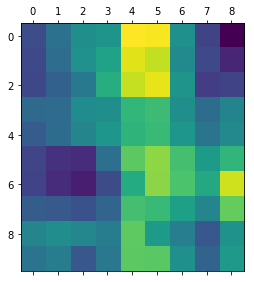

In [43]:
input_sentence = random.choice(pairs)[0]
target_sentence = random.choice(pairs)[1]
print("input sentence: ", input_sentence)
print("target_sentence: ", target_sentence)

output_words, attentions = evaluate(input_sentence)
print("output words: ", output_words)
print("attentions: ", attentions)
plt.matshow(attentions.numpy())

For a better experience we will do the extra work of adding axes and labels:

In [46]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cas = ax.matshow(attentions.numpy(), cmap = 'bone')
    fig.colorbar(cas)
    
    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    plt.close()
    

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print("input sentence: ", input_sentence)
    print("output sentence: ", ' '.join(output_words))
    
    show_attention(input_sentence, output_words, attentions)


/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


input sentence:  she is in low spirits today .
output sentence:  immoral immoral etala etala tot solitaires solitaires serre brulures perspicace


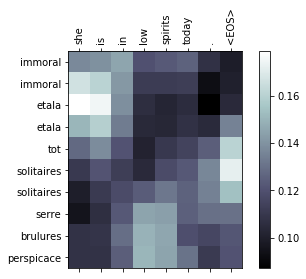

In [48]:
evaluate_and_show_attention(random.choice(pairs)[0])

/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


input sentence:  i am ready to die .
output sentence:  fabuleux ambitieuse pareille audace brillants brillants audace brillants cloturer impatients


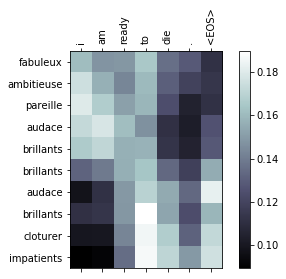

In [49]:
evaluate_and_show_attention(random.choice(pairs)[0])

/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/common/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


input sentence:  you re the teacher .
output sentence:  fabuleux ambitieuse pareille adversaire conteste contente contente prevu contente contente


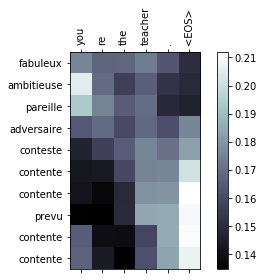

In [50]:
evaluate_and_show_attention(random.choice(pairs)[0])